[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sensioai/blog/blob/master/042_cnns/cnns.ipynb)

# Redes Neuronales Convolucionales

En posts anteriores hemos presentado varias arquitecturas diferentes de `redes neuronales`. Algunos ejemplos son el [`Perceptrón Multicapa`](https://sensioai.com/blog/023_mlp_backprop) o las [`redes neuronales recurrentes`](https://sensioai.com/blog/034_rnn_intro), las cuales hemos aplicado para [predicción de series temporales](https://sensioai.com/blog/035_rnn_forecast) y varias aplicaciones de [lenguaje](https://sensioai.com/blog/038_clasificacion_texto). En este post vamos a presentar una nueva arquitectura de `red neuronal` conocida como `red neuronal convolucional`, especialmente diseñada para trabajar con imágenes.

## Introducción

Las `redes neuronales convolucionales` (CNNs) surgieron del estudio del córtex visual del cerebro y se han utilizado en el reconocimiento de imágenes desde la década de los 80. En los últimos años, gracias al aumento de la potencia computacional, la cantidad de datos de entrenamiento disponibles y los trucos ya explicados anteriormente para entrenar redes profundas, las CNNs han logrado lograr un rendimiento sobrehumano en algunas tareas visuales complejas. Este tipo de red se puede encontrar en servicios de búsqueda de imágenes, coches autónomos, sistemas de clasificación de vídeo automático y muchas otras aplicaciones. Además, las CNNs no se limitan a la percepción visual, también tienen éxito en tareas como el reconocimiento de voz y el procesamiento de datos tridimensionales.

### El córtex visual

Las neuronas del córtex visual tienen un pequeño *campo receptivo local*, lo que significa que reaccionan solo a los estímulos visuales ubicados en una región limitada del campo visual. Los campos receptivos de diferentes neuronas pueden superponerse y juntos forman el campo visual completo.

![](https://mymlpics.s3.eu-de.cloud-object-storage.appdomain.cloud/visual_cortex.png)

Las neuronas de las primeras capas del córtex visual reaccionan solo ante ciertos patrones simples, como por ejemplo líneas horizontales mientras que otras reaccionan a líneas verticales (dos neuronas pueden tener el mismo campo receptivo pero reaccionan a diferentes orientaciones de línea). En las capas siguientes, las neuronas tienen campos receptivos más grandes y reaccionan a patrones más complejos, que pueden ser combinaciones de patrones de nivel inferior, construyendo de esta manera una jerarquía en diferentes capas que resultan finalmente en las formas y colores que vemos.

Basándose en estos conceptos, Yann LeCunn introdujo las CNNs en 1998 en la famosa arquitectura [LeNet-5](https://colab.research.google.com/drive/1fqxaTs-Ux9KQHyCJsToFTZwSNoHv9rKe#scrollTo=CMK6qB1EdfqC), utilizada por los bancos para reconocer de manera automática los números manuscritos en cheques para un procesamiento más rápido.

## La Capa Convolucional

Como veremos más adelante, las `redes convolucionales` están formadas por varias capas con diferente responsabilidad. De entre estas capas, la más importante es la `capa convolucional` la cual es responsable de identificar y construir las diferentes formas, colores y texturas de manera similar al córtex visual. Para llevar a cabo esta tarea usaremos un conjunto de *filtros* (también llamados *kernels*) los cuales deslizaremos por toda la imagen aplicando la operación *convolución*. Esta operación consiste en aplicar el producto escalar entre el filtro y los píxeles de la imagen cubiertos por el filtro, lo que se conoce como el *campo receptivo* (o *receptive field*). En el siguiente gif puedes ver esta operación en acción, en la que tenemos un filtro de 3x3 el cual deslizamos por nuestra imagen, la cual tiene una resolución de 5x5. Para cada posible posición del filtro dentro de la imagen, calculamos el producto de cada pixel por el valor del filtro correspondiente y guardamos el resultado en el mapa de salida.

![](https://miro.medium.com/max/1052/1*GcI7G-JLAQiEoCON7xFbhg.gif)

En este segundo ejemplo estamos aplicando la misma operación, pero ahora en el caso de que nuestra imagen tenga 3 canales (una imagen en color RGB). En este caso, nuestros filtros también tienen 3 canales. Además estamos aplicando más de un filtro, lo cual resulta en número de canales en el mapa de salida igual al número de filtros utilizados.

![](https://cdn-media-1.freecodecamp.org/images/gb08-2i83P5wPzs3SL-vosNb6Iur5kb5ZH43)

Vamos a ver un ejemplo de aplicación con imágenes reales, en este caso con imágenes del dataset CIFAR10 con el cual ya hemos trabajado anteriormente.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
device

'cuda'

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
import os
os.environ['KAGGLE_CONFIG_DIR']='/content/gdrive/MyDrive/2-SIS421/kaggle'

In [5]:
# Reemplaza 'dataset-name' con el nombre del conjunto de datos en la URL
!kaggle datasets download -d juniorbueno/rating-opencv-emotion-images

 76% 41.0M/53.9M [00:00<00:00, 113MB/s]
100% 53.9M/53.9M [00:00<00:00, 132MB/s]


In [6]:
import zipfile

with zipfile.ZipFile('/content/rating-opencv-emotion-images.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

In [7]:
import os
PATH = 'Images/train'
classes = os.listdir(PATH)
classes
print(classes)

['Happy', 'Angry', 'Disgust', 'Neutral', 'Sad', 'Surprise', 'Fear']


In [8]:
trainimgs, trainlabels = [], []

for i, lab in enumerate(classes):
  paths = os.listdir(f'{PATH}/{lab}')
  print(f'Categoría: {lab}. Imágenes: {len(paths)}')
  paths = [p for p in paths if p[-3:] == "jpg"]
  trainimgs += [f'{PATH}/{lab}/{img}' for img in paths]
  trainlabels += [i]*len(paths)

Categoría: Happy. Imágenes: 7215
Categoría: Angry. Imágenes: 3995
Categoría: Disgust. Imágenes: 436
Categoría: Neutral. Imágenes: 4965
Categoría: Sad. Imágenes: 4830
Categoría: Surprise. Imágenes: 3171
Categoría: Fear. Imágenes: 4097


In [9]:
PATH2 = 'Images/validation'
classes2 = os.listdir(PATH)
classes2
print(classes2)

['Happy', 'Angry', 'Disgust', 'Neutral', 'Sad', 'Surprise', 'Fear']


In [10]:
testimgs, testlabels = [], []

for i, lab in enumerate(classes2):
  paths = os.listdir(f'{PATH2}/{lab}')
  print(f'Categoría: {lab}. Imágenes: {len(paths)}')
  paths = [p for p in paths if p[-3:] == "jpg"]
  testimgs += [f'{PATH}/{lab}/{img}' for img in paths]
  testlabels += [i]*len(paths)

Categoría: Happy. Imágenes: 879
Categoría: Angry. Imágenes: 491
Categoría: Disgust. Imágenes: 55
Categoría: Neutral. Imágenes: 626
Categoría: Sad. Imágenes: 594
Categoría: Surprise. Imágenes: 416
Categoría: Fear. Imágenes: 528


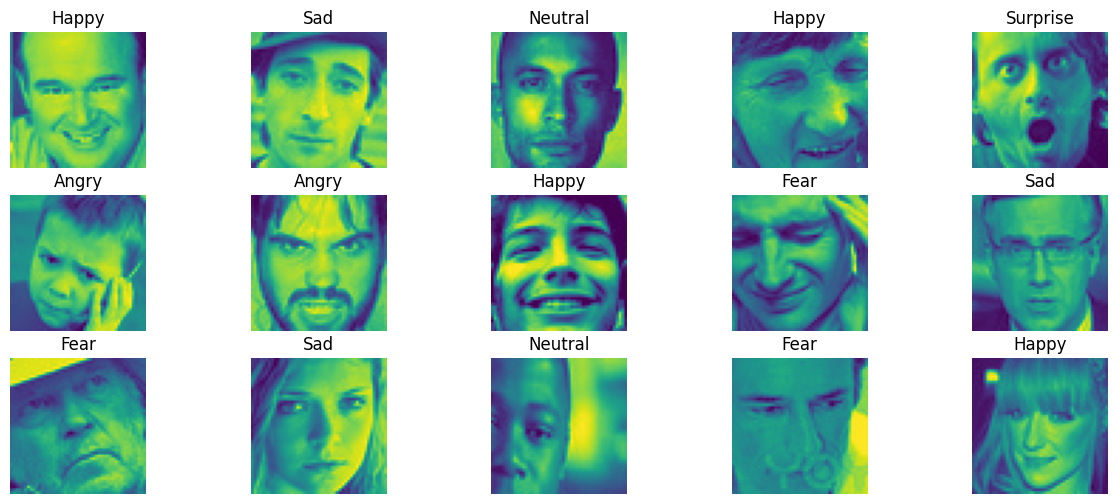

In [11]:
import random
from skimage import io
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3,5, figsize=(15,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(trainimgs)-1)
    img = io.imread(trainimgs[ix])
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(classes[trainlabels[ix]])
plt.show()

In [12]:
import numpy as np
trainimgs_array = np.array(trainimgs)
trainlabels_array = np.array(trainlabels)
testimgs_array = np.array(testimgs)
testlabels_array = np.array(testlabels)
print(trainimgs_array.shape)

(28709,)


In [13]:
import torch
from PIL import Image
device = "cuda" if torch.cuda.is_available() else "cpu"

class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y, trans, device):
    self.X = X
    self.y = y
    self.trans = trans
    self.device = device

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    # cargar la imágen
    img = io.imread(self.X[ix])
    #print(img)
    # Convertir la imagen a formato RGB
    rgb_img = Image.fromarray(img).convert("RGB")
    #print(rgb_img)
    # aplicar transformaciones
    #print(f"imagen: {img}")
    if self.trans:
      img = self.trans(image=np.array(rgb_img))["image"]
      #print(img.shape)
    return torch.from_numpy(img / 255.).float().permute(2,0,1), torch.tensor(self.y[ix])

In [14]:
import albumentations as A

trans = A.Compose([
    A.Resize(48, 48),
    A.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0)
])

dataset = {
    'train': Dataset(trainimgs, trainlabels, trans, device),
    'test': Dataset(testimgs, testlabels, trans, device)
}

len(dataset['train']), len(dataset['test'])

(28709, 3589)

In [15]:
dataset['train'][5]

(tensor([[[0.7647, 0.8196, 0.8118,  ..., 0.0980, 0.1765, 0.6275],
          [0.8235, 0.8157, 0.8353,  ..., 0.1098, 0.1451, 0.5529],
          [0.8196, 0.8196, 0.8196,  ..., 0.0824, 0.0863, 0.4039],
          ...,
          [0.9804, 0.9765, 0.9882,  ..., 0.0157, 0.0588, 0.1137],
          [0.9804, 0.9843, 0.9765,  ..., 0.0941, 0.1333, 0.1255],
          [0.9765, 0.9882, 0.9843,  ..., 0.0863, 0.1020, 0.1176]],
 
         [[0.7647, 0.8196, 0.8118,  ..., 0.0980, 0.1765, 0.6275],
          [0.8235, 0.8157, 0.8353,  ..., 0.1098, 0.1451, 0.5529],
          [0.8196, 0.8196, 0.8196,  ..., 0.0824, 0.0863, 0.4039],
          ...,
          [0.9804, 0.9765, 0.9882,  ..., 0.0157, 0.0588, 0.1137],
          [0.9804, 0.9843, 0.9765,  ..., 0.0941, 0.1333, 0.1255],
          [0.9765, 0.9882, 0.9843,  ..., 0.0863, 0.1020, 0.1176]],
 
         [[0.7647, 0.8196, 0.8118,  ..., 0.0980, 0.1765, 0.6275],
          [0.8235, 0.8157, 0.8353,  ..., 0.1098, 0.1451, 0.5529],
          [0.8196, 0.8196, 0.8196,  ...,

Una vez convertidas todas las imágenes a arrays de `Numpy`, vamos a visualizar un ejemplo aleatorio.

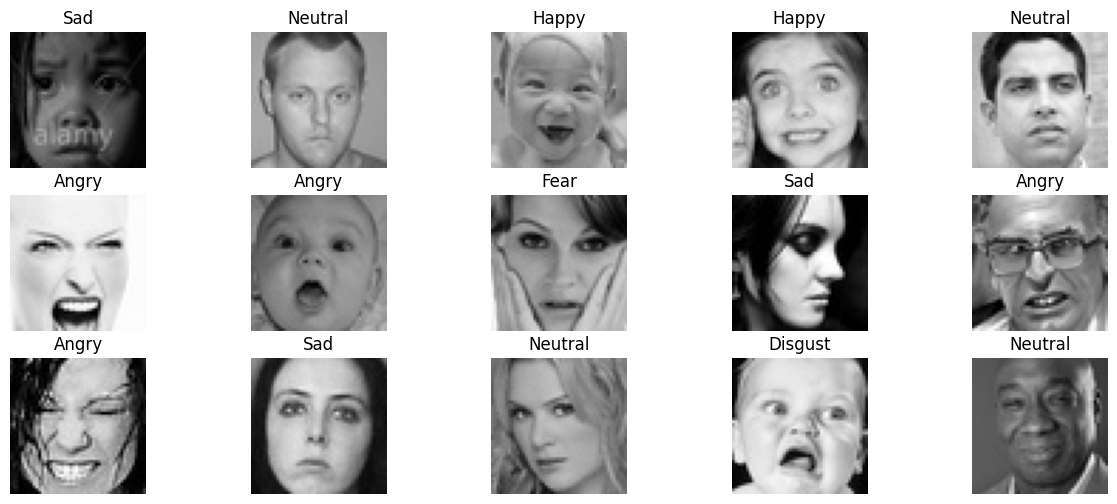

In [16]:
fig, axs = plt.subplots(3,5, figsize=(15,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(dataset['train'])-1)
    img, lab = dataset['train'][ix]
    #print(img.shape)
    ax.imshow(img.permute(1,2,0))
    ax.axis('off')
    ax.set_title(classes[lab])
plt.show()

In [30]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=64, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=256, shuffle=False)
}

imgs, labels = next(iter(dataloader['train']))
imgs.shape

torch.Size([64, 3, 48, 48])

### Implementación en Pytorch

En `Pytorch` tenemos implementada la capa convolucional en el clase `torch.nn.Conv2D`. A esta capa le pasamos como parámetros el número de canales de la imagen a la entrada, el número de filtros, el tamaño del filtro y otros parámetros relevantes de los que hablaremos más adelante. Si miras en la [documentación](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html), esta capa espera un tensor a la entrada con dimensiones $(N,C_{in},H,W)$, dónde $N$ es el tamaño del *batch*, $C_{in}$ es el número de canales del mapa de entrada, $H$ es el alto y $W$ el ancho del mapa.

In [18]:
# img.shape, img.dtype

In [19]:
# img_tensor = torch.from_numpy(img/255)
# img_tensor.shape, img_tensor.dtype

In [20]:
# img_tensor = img_tensor.unsqueeze(0)
#img_tensor.shape, img_tensor.dtype

In [21]:
# img_tensor = img_tensor.permute(0, 2, 4, 1, 3).float()
# img_tensor.shape, img_tensor.dtype

In [22]:
# convertir la imágen en tensor con dimensiones (N, C_in, H, W)

Como puedes ver las dimensiones del tensor de salida son diferentes al tensor de entrada. En primer lugar, el número de canales del mapa de entrada ahora es el número de filtros aplicados (el resultado de aplicar cada filtro se guarda en un canal). En cuanto al ancho y alto, dependerá de la relación entre el tamaño de la imagen y el del filtro. Puedes calcular estas dimensiones de la siguiente manera

$$ o = \lfloor \frac{n+2p-m}{s} \rfloor + 1 $$

donde $o$ es la dimensión de salida, $n$ la de entrada, $m$ es el tamaño del filtro y $p$ y $s$ son dos parámetros con los que podemos jugar para ajustar el tamaño de salida. $p$ es el *padding* y consiste en el número de valores extra que añadimos en los bordes para aumentar el tamaño de la entrada. $s$ es el *stride*, y controla el número de pixeles que el filtro salta en cada paso. $\lfloor \cdot \rfloor$ es el operador *floor*, que redondea cualquier resultado a la baja.

Usar $p = 1$ y $s = 1$ con un filtro de 3x3 no cambiará el tamaño de la imagen.

En una `red convolucional` tendremos varias de estas `capas convolucionales` en diferentes capas consecutivas, de manera que las entradas a unas capas serán las salidas de las anteriores. De esta manera, la red será capaz de construir patrones cada vez más elaborados a partir de patrones más sencillos. Puedes ver una animación del funcionamiento de esta capa en el siguiente [vídeo](https://www.youtube.com/watch?v=f0t-OCG79-U). También, en el siguiente gif, puedes ver un ejemplo de aplicación.

![](https://thumbs.gfycat.com/AffectionateMemorableGreyhounddog-size_restricted.gif)


## Capas de *Pooling*

Si bien hemos visto que jugando con los tamaños del filtro, *stride* y *padding* podemos controlar el tamaño de los mapas generados por las capas convolucionales, es también común el uso de capas *pooling* para reducir los mapas de características.

![](https://miro.medium.com/max/1456/1*WvHC5bKyrHa7Wm3ca-pXtg.gif)

Estas capas también aplican un filtro sobre su entrada, pero en este caso es un solo filtro que además no tiene parámetros sino que aplica una función predeterminada en su campo receptivo (mínimo, máximo, promedio, etc). La idea detrás del uso de este tipo de capas es la de reducir la resolución de los mapas de características, reduciendo así el coste computacional para entrenar la `red neuronal`, pero manteniendo las características importantes para el reconocimiento de patrones.

## Redes Convolucionales

Una vez hemos visto los comoponentes principales de las `redes convolucionales` vamos a ver un ejemplo de cómo podemos implementar una red convolucional completa para, en este caso, la clasificación de las imágenes en el dataset MNIST. En primer lugar descargamos el dataset.

In [23]:
import torchvision

resnet = torchvision.models.squeezenet1_0()
resnet

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

Vamos a definir una `red convolucional` con varias `capas convolucionales` y `capas de pooling`. Para poder clasificar las imágenes, conectaremos las salidas de la última capa de la red convolucional con un `MLP` para obtener las predicciones finales.

In [26]:
from torchvision.models import squeezenet1_0
def block(c_in, c_out, k=3, p=1, s=1, pk=2, ps=2):
    return torch.nn.Sequential(
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(pk, stride=ps)
    )

def block2(c_in, c_out):
    return torch.nn.Sequential(
        torch.nn.Linear(c_in, c_out),
        torch.nn.ReLU()
    )

class CNN(torch.nn.Module):
  def __init__(self, n_channels=3, n_outputs=7):
    super().__init__()
    # Cargar el modelo preentrenado SqueezeNet 1.0
    self.pretrained_model = squeezenet1_0(pretrained=True)
    # Cambiar la capa de salida para adaptarse al número de clases
    self.pretrained_model.classifier[1] = nn.Conv2d(512, 1000, kernel_size=(1,1), stride=(1,1))
    self.features = self.pretrained_model.features
    self.classifier = self.pretrained_model.classifier
    self.fc = torch.nn.Linear(512*2*2, n_outputs)

  def forward(self, x):
    x = self.features(x)
    #print(x.shape)
    #x = self.classifier(x)
    #print(x.shape)
    x = x.view(x.shape[0], -1)
    #print(x.shape)
    x =self.fc(x)
    #print(x.shape)
    return x

In [27]:
model = CNN()

output = model(torch.randn(64, 3, 48, 48))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-b66bff10.pth
100%|██████████| 4.78M/4.78M [00:00<00:00, 61.3MB/s]


Utilizando capas convolucionales con filtros de 3x3, *padding* 1 y *stride* 1, mantenemos las dimensiones constantes dejando la responsabilidad de reducir la resolución a las capas *pooling*. Tras cada capa convolcuional, el número de canales corresponde con el número de filtros aplicados. Para conectar la última salida de la capa convolucional a la capa lineal, tenemos que estirar el último mapa de características en un vector de una sola dimensión.

Ahora, podemos entrenar la red utilizando nuestro bucle de entrenamiento.

In [32]:
from tqdm import tqdm
import numpy as np

def fit(model, dataloader, epochs=10):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

In [33]:
model = CNN()
fit(model, dataloader)

val_loss 1.48638 val_acc 0.40260: 100%|██████████| 15/15 [00:03<00:00,  3.91it/s]


Epoch 1/10 loss 1.65814 val_loss 1.48638 acc 0.34545 val_acc 0.40260


val_loss 1.36752 val_acc 0.46068: 100%|██████████| 15/15 [00:02<00:00,  5.06it/s]


Epoch 2/10 loss 1.35892 val_loss 1.36752 acc 0.47694 val_acc 0.46068


val_loss 1.26079 val_acc 0.50755: 100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


Epoch 3/10 loss 1.27201 val_loss 1.26079 acc 0.50988 val_acc 0.50755


val_loss 1.23424 val_acc 0.50026: 100%|██████████| 15/15 [00:03<00:00,  4.94it/s]


Epoch 4/10 loss 1.20259 val_loss 1.23424 acc 0.53893 val_acc 0.50026


val_loss 1.22504 val_acc 0.51406: 100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


Epoch 5/10 loss 1.15059 val_loss 1.22504 acc 0.56131 val_acc 0.51406


val_loss 1.19125 val_acc 0.53490: 100%|██████████| 15/15 [00:03<00:00,  4.33it/s]


Epoch 6/10 loss 1.10813 val_loss 1.19125 acc 0.57737 val_acc 0.53490


val_loss 1.08478 val_acc 0.57974: 100%|██████████| 15/15 [00:03<00:00,  4.46it/s]


Epoch 7/10 loss 1.05925 val_loss 1.08478 acc 0.59747 val_acc 0.57974


val_loss 1.13016 val_acc 0.56927: 100%|██████████| 15/15 [00:03<00:00,  4.44it/s]


Epoch 8/10 loss 1.03389 val_loss 1.13016 acc 0.60515 val_acc 0.56927


val_loss 1.05800 val_acc 0.60448: 100%|██████████| 15/15 [00:02<00:00,  5.03it/s]


Epoch 9/10 loss 0.99953 val_loss 1.05800 acc 0.62216 val_acc 0.60448


val_loss 0.99738 val_acc 0.62870: 100%|██████████| 15/15 [00:03<00:00,  4.36it/s]

Epoch 10/10 loss 0.96899 val_loss 0.99738 acc 0.63189 val_acc 0.62870


Eleji un data set de el cual es de 28709 imagenes de entrenamiento y 3589 de validacion o prueba  estas imagenes son de 48x48,
eleji el modelo pre entrenado squeezenet1_0 que se destaca por su tamaño reducido y eficiencia, lo que lo hace adecuado para aplicaciones con restricciones computacionales. A pesar de su tamaño compacto, logra mantener un buen rendimiento en tareas de clasificación.


Bueno segun mis resultado para 5 epochs llego hasta un 50% de precision con los imagenes de prueba , al aumentar los epochs a 10 obtube una precision de 62.8% con las imagenes de prueba pero con los de entrenamiento es del 63.2%  , estos resultados pueden mejorar aunmentando los epochs

## Resumen

En este post hemos introducido la arquitectura de `red neuronal` conocida como `red neuronal convolucional`. Este tipo de redes, inspiradas en el funcionamiento del córtex visual, están especialmente diseñadas para trabajar con imágenes. Gracias a la aplicación de la `capa convolucional`, la red será capaz de reconocer diferentes formas, colores y texturas que, de manera jerárquica, irá componiendo en estructuras cada vez más complejas para poder llevar a cabo su tarea de la mejor forma posible. En futuros posts hablaremos sobre diferente arquitecturas de CNN que han aparecido durante los últimos años y que podemos utilizar para nuestras aplicaciones.